# pix2pix inspired image to image translation on the MNIST dataset

#### Peter Yegorov
March 2024

In this project I will design a conditional GAN (cGAN) architecture to perform even to odd and odd to even digit mapping on the MNIST dataset. pix2pix image to image architecture will be referenced as a general guideline. 

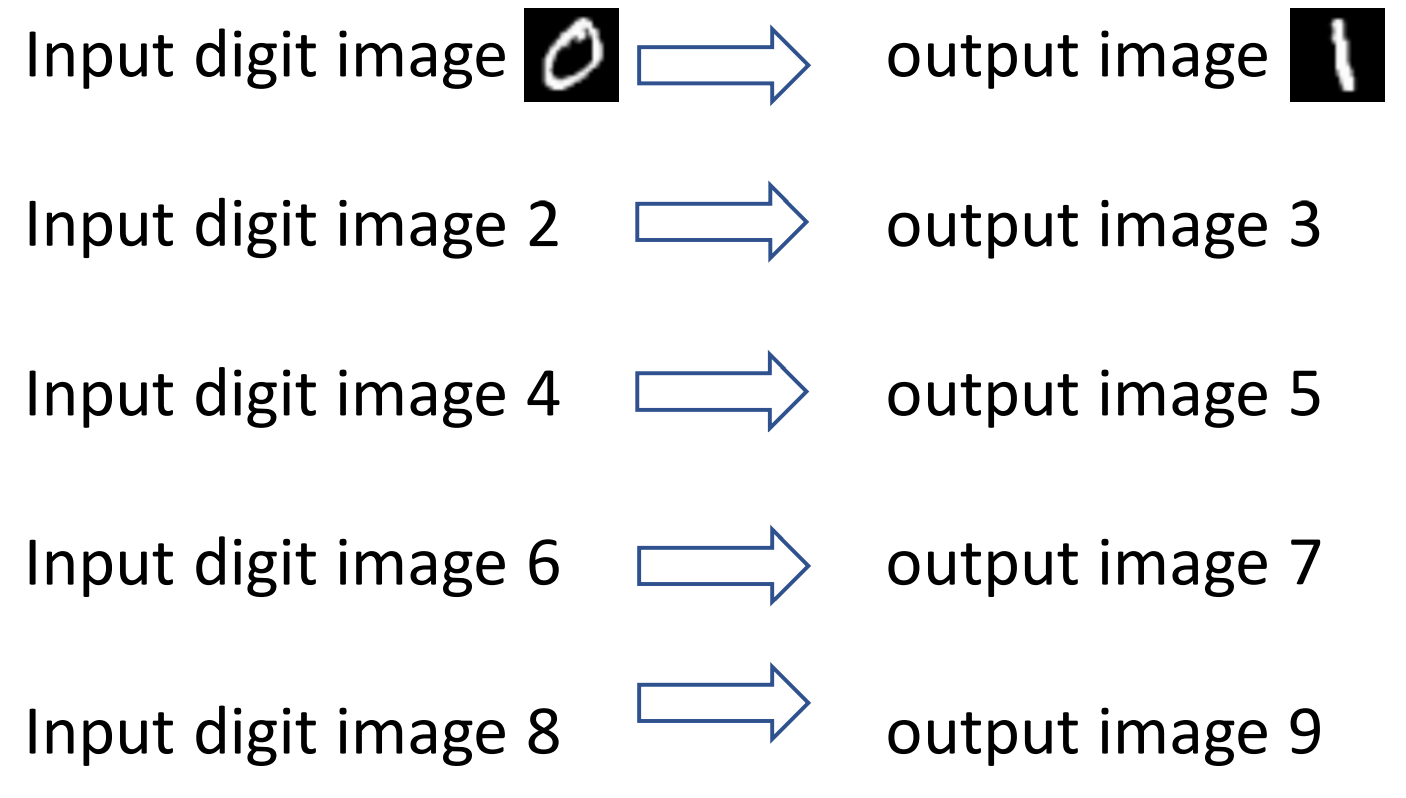

In [1]:
from IPython.display import Image, display
# Adjust width and height as desired
display(Image(filename="C:\\Users\\peter\\OneDrive\\Pictures\\Screenshots\\Screenshot 2024-03-05 212135.png", width=500, height=300))

# MNISTNextDigitDataset class

#### Overview

The MNISTNextDigitDataset class is a custom dataset designed to work with the MNIST dataset. It creates pairs of images where the first image is a digit from the MNIST dataset, and the second image is a random image of the next sequential digit. For example, if the first image is a '3', the second image will be a random '4'. This dataset is particularly useful for tasks like this, that involve predicting sequences or understanding the relationship between different classes in a dataset. Randomness of labels will allow the generator to learn different patterns, making the output more creative during inference. 

#### Methods

`prepare_next_digit_pairs(self)`

This method organizes the MNIST dataset into pairs of sequential digit images. It iterates through the entire MNIST dataset, groups images by their digit label, and then for each image of digit n, it randomly selects an image of digit n+1 to pair with it. This method populates the pairs attribute with these image pairs.

Process:

1. Initialize an empty list for each digit (0 through 9) to store images by their label.
2. Iterate through the MNIST dataset, appending each image to its corresponding label list.
3. For each digit, pair each image with a random image of the next sequential digit (with digit '9' wrapping around to digit '0').
4. Append these pairs to the pairs list.

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import random

class MNISTNextDigitDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.prepare_next_digit_pairs()

    def prepare_next_digit_pairs(self):
        self.pairs = []
        digit_images = [[] for _ in range(10)]
        for image, label in self.mnist_dataset:
            digit_images[label].append(image)

        for digit, images in enumerate(digit_images):
            next_digit = (digit + 1) % 10
            next_digit_images = digit_images[next_digit]

            # Ensure variability by selecting a random next digit image for each current image
            for image in images:
                if next_digit_images:
                    next_image = random.choice(next_digit_images)
                    self.pairs.append((image, next_image))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        current_image, next_image = self.pairs[idx]
        return current_image, next_image

This code below defines a series of transformations to be applied to the MNIST dataset:

`transforms.ToTensor()`: Converts the images into PyTorch tensors.

`transforms.Normalize((0.5,), (0.5,))`: Normalizes the tensor images by setting their mean to 0.5 and their standard deviation to 0.5. This normalization is done channel-wise; since MNIST images are grayscale, there's only one channel.

The code initializes a custom dataset called MNISTNextDigitDataset for both the training and testing data. Finally, the code visualizes the first four pairs from the transformed training dataset. Here we can see the differences between each label showing the same digit.

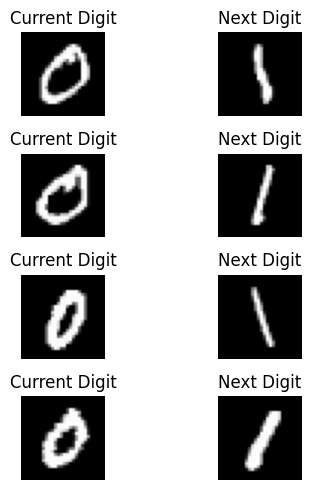

In [14]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load the original MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Initialize custom dataset
mnist_train = MNISTNextDigitDataset(mnist_train)
mnist_test = MNISTNextDigitDataset(mnist_test)

# Plot some examples
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(5, 5))
for i in range(4):
    current_image, next_image = mnist_train[i]
    axes[i, 0].imshow(current_image.squeeze(), cmap='gray')
    axes[i, 0].set_title('Current Digit')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(next_image.squeeze(), cmap='gray')
    axes[i, 1].set_title('Next Digit')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Model Definition

Code below defines a neural network architecture inspired by the U-Net model. The UNetDown and UNetUp classes represent the downsampling and upsampling blocks of the network, respectively, incorporating convolutional layers, batch normalization, activation functions (LeakyReLU or ReLU based on the pix2pix architecture), and optional dropout for regularization. The Generator class constructs the overall U-Net architecture by sequentially connecting multiple downsampling layers to encode the input image into a compact representation, followed by upsampling layers that progressively increase the spatial resolution of the representation while incorporating skip connections from the downsampling layers to preserve spatial information. The final layer of the generator uses a convolutional transpose layer followed by a tanh activation function to produce an output image with the same dimensions as the input. Skip connections are implemented by concatenating the features from downsampling layers with the corresponding features in the upsampling path, aiming to enhance the flow of gradients and detail information through the network, making it suitable for tasks that require high fidelity reconstruction, such as image-to-image translation.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=4, stride=2, padding=1, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Initial downsampling
        self.down1 = UNetDown(1, 128, normalize=False)
        self.down2 = UNetDown(128, 256)
        self.down3 = UNetDown(256, 512)
        self.down4 = UNetDown(512, 1024, dropout=0.5)
        
        # Upsampling layers
        self.up1 = UNetUp(1024, 512, 5, dropout=0.5)
        self.up2 = UNetUp(1024, 256, 5)
        self.up3 = UNetUp(512, 128)
        
        # Final layer to produce an image
        self.final = nn.Sequential(
            nn.ConvTranspose2d(256, 1, 4, 2, 1, bias=False),  # Adjusted to ensure 28x28 output
            nn.Tanh()
        )
    
    def forward(self, x):
        
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Decoder with skip connections
        u1 = self.up1(d4)
        u1_cat = torch.cat((u1, d3), dim=1)  # Concatenate with corresponding encoder layer
        u2 = self.up2(u1_cat)
        u2_cat = torch.cat((u2, d2), dim=1)
        u3 = self.up3(u2_cat)
        u3_cat = torch.cat((u3, d1), dim=1)

        # Final output
        final = self.final(u3_cat)

        return final

Code below defines a Discriminator class. The Discriminator aims to distinguish between real images (from the dataset) and fake images (generated by the Generator). The architecture begins with a 32-channel convolutional layer, followed by a 64-channel layer, each with a stride of 2 to reduce the spatial dimensions by half after each convolution. Batch normalization is applied after the second convolution to normalize the outputs and improve the training dynamics. The final convolutional layer reduces the spatial dimensions significantly (using a stride of 6) and maps the depth to 1, preparing the output for a binary classification decision. A sigmoid activation function is applied at the end to squish the final output to a range between 0 and 1, which is suitable for binary classification tasks. This value represents the probability of the input image being real (as opposed to being generated). The forward method defines how the input image flows through the model. After processing by the sequential model, the output is flattened (using view(-1, 1).squeeze(1)) to produce a one-dimensional tensor where each element corresponds to the "realness" score of each input image.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input is an image tensor
            nn.Conv2d(1, 32, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # C128 - After removing the 256 convolution, we directly connect this layer to the final layer
            nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Final convolution adjusted to take 128 channels as input
            nn.Conv2d(64, 1, 4, stride=6, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image):
        output = self.model(image)
        # Flatten the output for binary classification
        return output.view(-1, 1).squeeze(1)

# Function to Initialize Weights

This function, `weights_init_normal`, is designed to initialize the weights of a neural network with a normal (Gaussian) distribution with a mean of 0.0 and a standard deviation of 0.02, accordint to the pix2pix paper. For batch normalization layers (BatchNorm2d), the function sets the weights to a normal distribution with a mean of 1.0 and a standard deviation of 0.02.

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# Training

This code outlines the training process for our setup, where a generator and discriminator networks are trained in opposition to each other on the MNIST dataset. The generator aims to produce images that mimic the next sequential digit from a given input image, while the discriminator tries to differentiate between real sequential digit images and the ones generated by the generator. The networks are initialized with weights using a specified normal distribution strategy. During training, both networks' parameters are optimized using the Adam optimizer, and loss is calculated using binary cross-entropy for the discriminator to assess real vs. fake images and a combination of binary cross-entropy and L1 loss for the generator. The training loop updates both models' weights through backpropagation based on their respective losses, iterating over the dataset for a predefined number of epochs while tracking and printing the losses to monitor the training progress.

#### Training the Discriminator (D)

Real images from the dataset are passed through D, which outputs probabilities indicating how likely it thinks these images are real. The loss (loss_real) is calculated using these probabilities, comparing them to a tensor of ones (representing "real").
Fake images generated by G (using noise or another input) are passed through D. Here, D outputs probabilities representing how likely it thinks these images are real. The loss (loss_fake) is calculated by comparing these probabilities to a tensor of zeros (representing "fake"). The total discriminator loss (loss_d) is the average of loss_real and loss_fake. This loss is then used to update D's parameters through backpropagation.

#### Training the Generator (G)

G generates output images from a conditional image. The generated images are passed through D to evaluate how real they appear. However, in this step, G's loss (loss_gan) is calculated by considering how D's predictions compare to a tensor of ones, because G wants to convince D that these fake images are real. An additional loss, such as L1 loss (loss_pixel), can be included to measure the difference between the generated images and the real images, encouraging the generator to produce images that are not just classified as real by D but also closely resemble the real images in a pixel-wise manner. The total generator loss (loss_g) is a combination of loss_gan and the pixel-wise loss, adjusted by a factor (lambda_pixel). G's parameters are updated based on this combined loss.


In [7]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming mnist_train and mnist_test are defined somewhere
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Apply the weight initialization function to the models
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss functions
criterion_gan = nn.BCELoss()
criterion_pixelwise = nn.L1Loss()

# Lists to track loss
losses_g = []
losses_d = []

# Training
num_epochs = 40
lambda_pixel = 100  # Weight for L1 loss

for epoch in range(num_epochs):
    for i, (current_image, next_image) in enumerate(train_loader):
        
        current_image = current_image.to(device)
        next_image = next_image.to(device)

        valid = torch.ones(current_image.size(0), requires_grad=False).to(device)
        fake = torch.zeros(current_image.size(0), requires_grad=False).to(device)

        # Train Discriminator

        optimizer_d.zero_grad()

        pred_real = discriminator(next_image)
        loss_real = criterion_gan(pred_real, valid)

        fake_images = generator(current_image)
        pred_fake = discriminator(fake_images.detach())
        loss_fake = criterion_gan(pred_fake, fake)

        loss_d = (loss_real + loss_fake) / 2
        loss_d.backward()
        optimizer_d.step()

        # Train Generator

        optimizer_g.zero_grad()

        pred_fake = discriminator(fake_images)
        loss_gan = criterion_gan(pred_fake, valid)
        loss_pixel = criterion_pixelwise(fake_images, next_image)

        loss_g = loss_gan + lambda_pixel * loss_pixel
        loss_g.backward()
        optimizer_g.step()
        
        if i % 250 == 0:
            losses_g.append(loss_g.item())
            losses_d.append(loss_d.item())

    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {loss_d.item()}] [G loss: {loss_g.item()}]")

[Epoch 1/40] [D loss: 0.45972976088523865] [G loss: 25.65884017944336]
[Epoch 2/40] [D loss: 0.4746253490447998] [G loss: 23.81102180480957]
[Epoch 3/40] [D loss: 0.42451077699661255] [G loss: 25.126033782958984]
[Epoch 4/40] [D loss: 0.36733853816986084] [G loss: 24.135801315307617]
[Epoch 5/40] [D loss: 0.6176500916481018] [G loss: 26.251285552978516]
[Epoch 6/40] [D loss: 0.3805631995201111] [G loss: 23.799009323120117]
[Epoch 7/40] [D loss: 0.45953041315078735] [G loss: 24.923858642578125]
[Epoch 8/40] [D loss: 0.47477978467941284] [G loss: 23.173416137695312]
[Epoch 9/40] [D loss: 0.4903292655944824] [G loss: 24.525867462158203]
[Epoch 10/40] [D loss: 0.3186410665512085] [G loss: 27.61423110961914]
[Epoch 11/40] [D loss: 0.45171645283699036] [G loss: 26.11896514892578]
[Epoch 12/40] [D loss: 0.38245952129364014] [G loss: 25.370906829833984]
[Epoch 13/40] [D loss: 0.434969961643219] [G loss: 28.610193252563477]
[Epoch 14/40] [D loss: 0.5798081159591675] [G loss: 24.993473052978516]

## Plot the losses

The following code creates a plot to visualize the training losses of the generator and discriminator

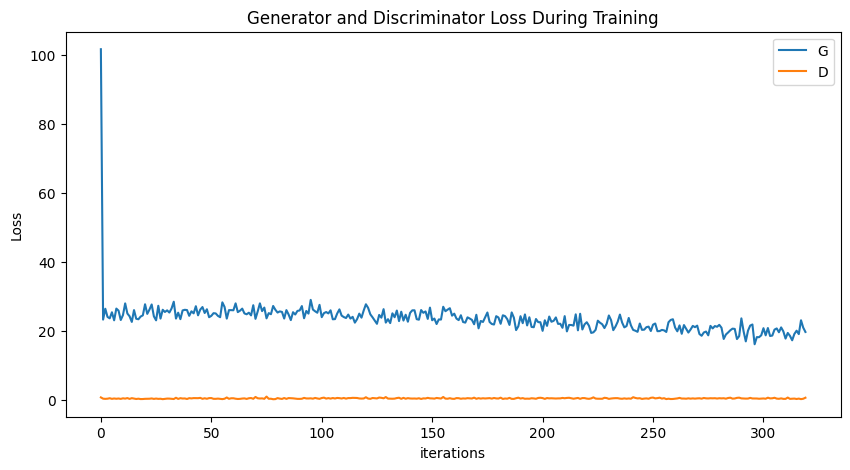

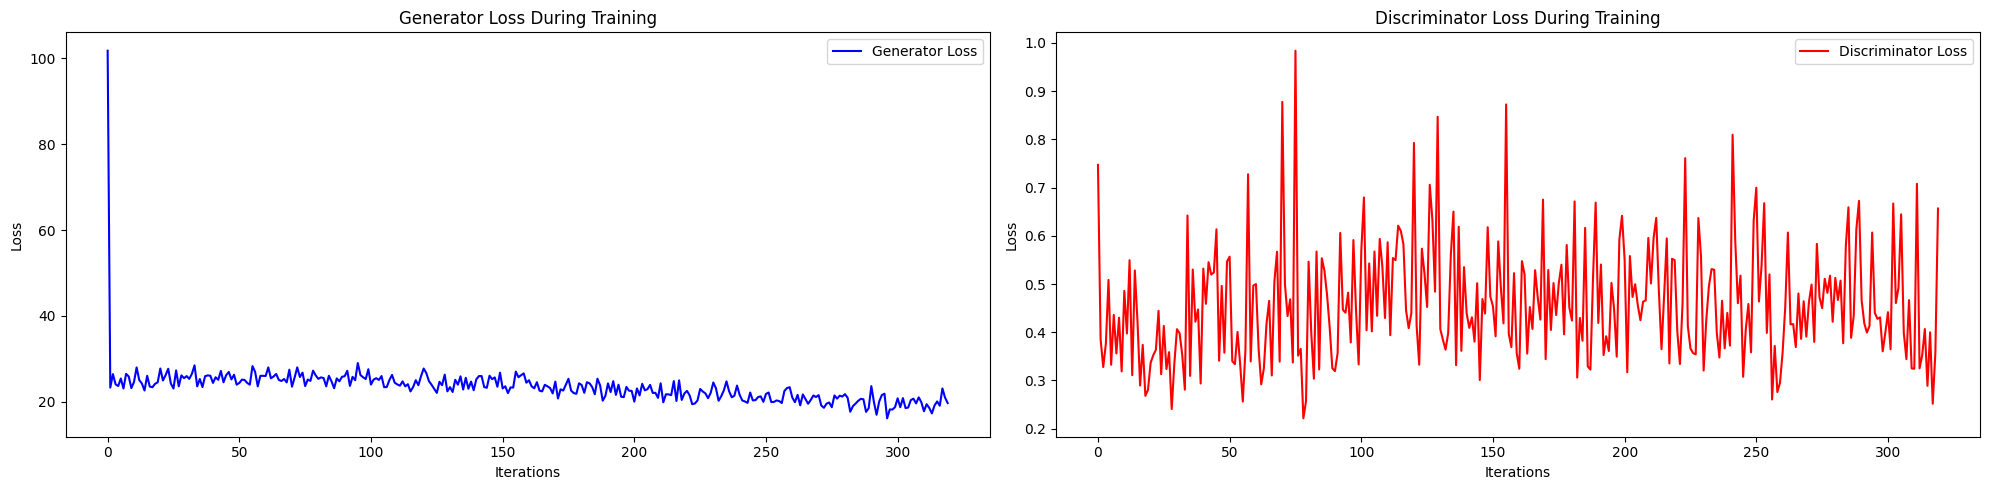

In [10]:
# Plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g,label="G")
plt.plot(losses_d,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the losses
plt.figure(figsize=(20, 5))

# Plot for Generator
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(losses_g, label="Generator Loss", color='blue')
plt.title("Generator Loss During Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Plot for Discriminator
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(losses_d, label="Discriminator Loss", color='red')
plt.title("Discriminator Loss During Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Plot 25 random examples from the test set

The code below sets the Generator model to evaluation mode (generator.eval()), which disables dropout and batch normalization layers to ensure consistent performance across different inputs.

The code randomly selects 25 unique indices from the MNIST test dataset and creates a Subset with these indices. This subset is then loaded using a DataLoader with a batch size of 25, ensuring all selected images are processed in one batch without shuffling.

Image Generation: For each batch of original images (current_image) from the test set, the Generator model produces corresponding generated images.

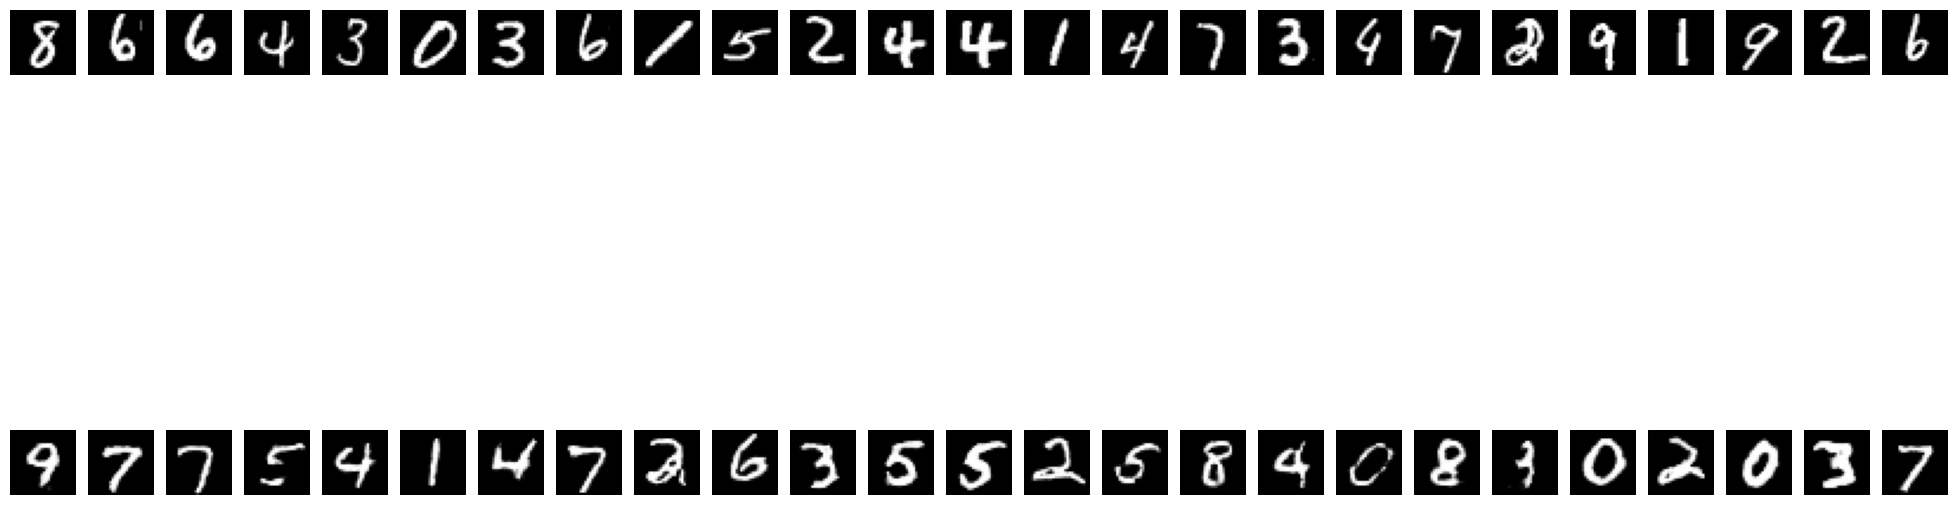

In [11]:
# Assuming generator is your trained Generator model
generator.eval()

# Randomly sample 10 images from the test dataset
indices = np.random.choice(len(mnist_test), 25, replace=False)
sample_dataset = torch.utils.data.Subset(mnist_test, indices)
sample_loader = DataLoader(sample_dataset, batch_size=25, shuffle=False)

with torch.no_grad():
    for current_image, _ in sample_loader:
        current_image = current_image.to(device)
        # Generate images
        generated_images = generator(current_image)
        current_image = current_image.cpu()
        generated_images = generated_images.cpu()
        
        # Plotting
        fig, axs = plt.subplots(2, 25, figsize=(25, 10))
        for i in range(25):
            axs[0, i].imshow(current_image[i].squeeze(), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(generated_images[i].squeeze(), cmap='gray')
            axs[1, i].axis('off')
        plt.show()
        break

# Result

The generator produces realistic looking images of the next digit. The results are different for every sample of the target pairing.